## Open EMG Data and Grasping Force signals

This code show how to open the  database of Emg signals and grasping force signal, disposable in extension " .m " in "EMG_force_datalog" path.

More details about record of signals, used protocol, used electromyography and experimental setup are presented in "EMG_force_datalog" folder

### Import libraries

In [288]:
import os, sys
processing_source_path = os.path.abspath('./Processing/')
sys.path.append(processing_source_path)
import ProcessingPipeline as pp

In [289]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt 
#import functions as func
import scipy.io
import seaborn as ns;
#import Ident as id
from sklearn.model_selection import cross_val_score

####  Read the datalog file that is in " .m " extension 


In [290]:
mat = scipy.io.loadmat('EMG_force_datalog/recording_force_v3.mat')     
emg = mat['emg'];
force=  mat['Force'];
Ts= 0.005;

#### Define th Signal EMG with the imput signal 


In [291]:
u1=emg[:,0];
u2=emg[:,1];
u3=emg[:,2];
u4=emg[:,3];
u5=emg[:,4];
u6=emg[:,5];
u7=emg[:,6];
u8=emg[:,7];
U=[u1,u2,u3,u4,u5,u6,u7,u8]
n_channels= len(U)

#### Define the grasping force with the output signal 

In [292]:
y=force;
y.shape=(-1,1)
nit=y.shape[0]

#### Sample time and recording time settings

In [293]:
# sample time 

Ts=0.005
# datalog recording time 
t  =np.linspace(1, Ts*nit-Ts, nit)

### Plot the EMG and Force signals

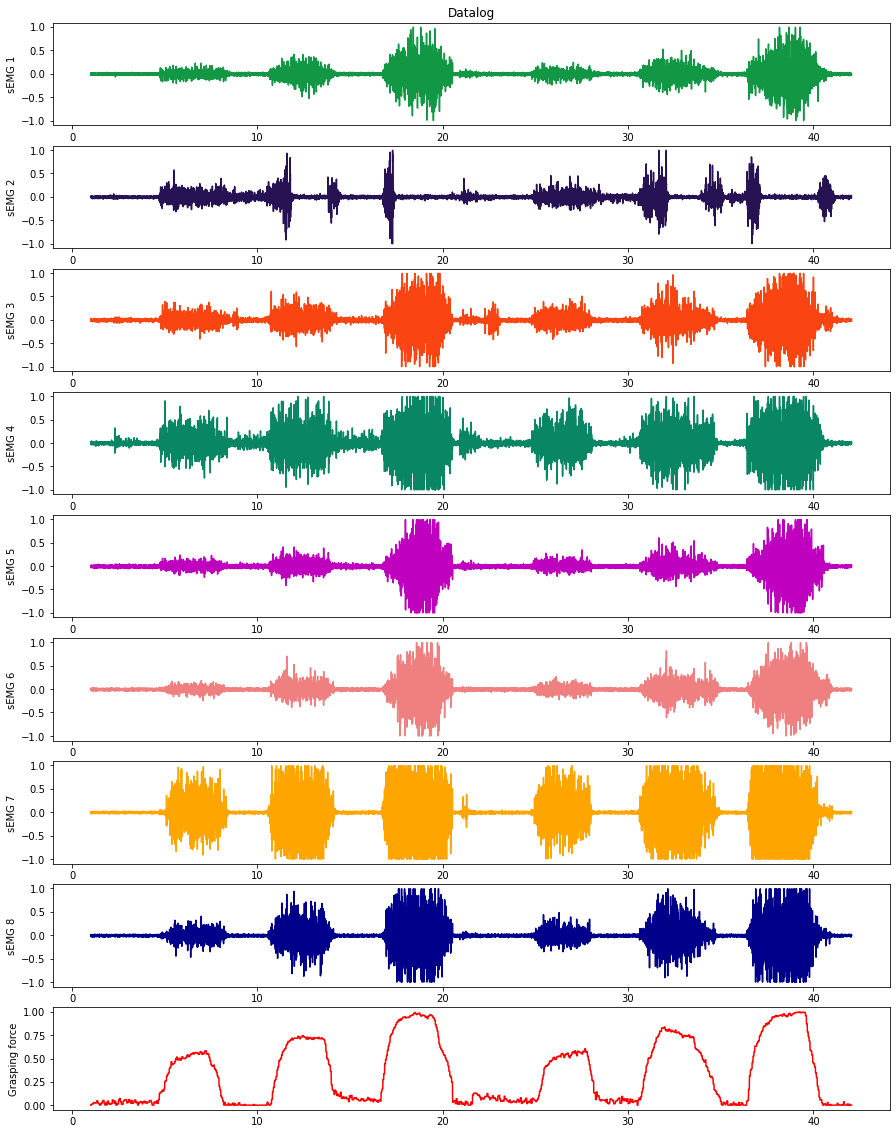

In [294]:
#plt.style.use('dark_background')
fig, axs = plt.subplots(9, 1, figsize=(15, 20))

axs[0].set_title('Datalog')
axs[0].plot(t, u1, '#129845')
axs[0].set_ylabel('sEMG 1')
axs[0].set_xlabel('Time(s)')

axs[1].plot(t, u2, '#271254')
axs[1].set_ylabel('sEMG 2')

axs[2].plot(t, u3, '#FA4411')
axs[2].set_ylabel('sEMG 3')

axs[3].plot(t, u4, '#098765')
axs[3].set_ylabel('sEMG 4')

axs[4].plot(t, u5, 'm')
axs[4].set_ylabel('sEMG 5')

axs[5].plot(t, u6, 'lightcoral')
axs[5].set_ylabel('sEMG 6')

axs[6].plot(t, u7, 'orange')
axs[6].set_ylabel('sEMG 7')

axs[7].plot(t, u8, 'darkblue')
axs[7].set_ylabel('sEMG 8')

axs[8].plot(t, y, 'red')
axs[8].set_ylabel('Grasping force')

plt.savefig('EMG_force_datalog/movements_datalog_fig.png')
plt.show()

## Comput Signal Features 

In [295]:
NormMinMax = pp.NormMinMax(axis=1)

To extract the sEMG features is used an overlapping window of 400 ms
with an increment of 125 ms

In [296]:
Window_length = int(0.4/Ts)
window_step = int(0.125/Ts)
print('Samples per Window',Window_length)
print('Samples per Window Step',window_step)

Samples per Window 80
Samples per Window Step 25


In [297]:
features=[]
force_ds=[]
for step in np.arange(0, nit- Window_length, window_step): # windowing
    features_ch=[]
    for ch in range(n_channels): # get the window  and comput the features for each EMG channel 
        emg_data = emg[step:Window_length+step,ch].reshape(1,-1) # moving window for each step
        all_features = {
                    # time domain features
                    #Features based on energy information 
                    'mav': np.mean(np.abs(emg_data), axis=1),  # MAV (Mean Absolute Value)
                    'rms': np.sqrt(np.mean(emg_data**2, axis=1)),  # RMS (Root Mean Square)
                    'wl': np.sum(np.abs(np.diff(emg_data, axis=1)), axis=1),  # WL (Waveform Length)
                    }

        features_ch+=[ np.hstack([all_features[feature][:, np.newaxis] for feature in all_features.keys()])]

    features+=[features_ch] # stock the features array
    force_ds+=[np.mean(force[step:Window_length+step,:])] # stock the mean of force in this windowing

features= NormMinMax(np.hstack(features))
force_ds=np.hstack(force_ds)
print('n_channels:',features.shape[0],'samples:',features.shape[1],'N_features:',features.shape[2])
features_name= [feature for feature in all_features.keys()]
print('Extracted Features',features_name)
          

n_channels: 8 samples: 334 N_features: 3
Extracted Features ['mav', 'rms', 'wl']


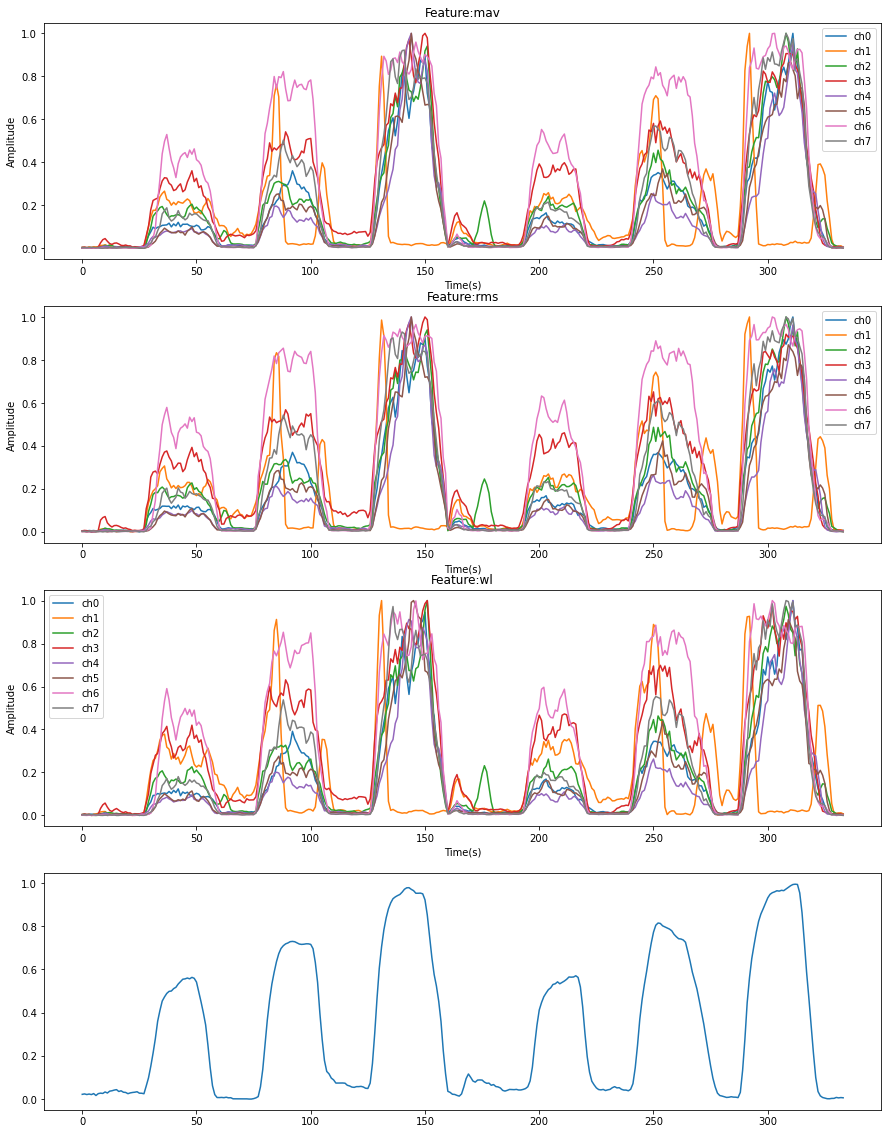

In [298]:
fig, axs = plt.subplots(features.shape[2]+1, 1, figsize=(15, 20))
colors_list=['#129845','#271254','#FA4411']
for n,feature in enumerate(features_name):
    axs[n].set_title(f'Feature:{feature}')

    axs[n].plot(features[:,:,n].T)
    axs[n].set_ylabel('Amplitude')
    axs[n].set_xlabel('Time(s)')
    axs[n].legend([f'ch{ch}'for ch in range(n_channels)])

axs[-1].plot(force_ds.T)
plt.savefig('EMG_force_datalog/Extracted_Features_fig.png')
plt.show()

### State Space Identification System

* Selecting the used channels

In [299]:
# select the used channels
used_channels=[5,6,7]

* System order, input array and output array definitions

In [300]:
# Definition of input u
u = np.hstack([features[channel] for channel in used_channels]).T
u[:, :10] = np.zeros((u.shape[0], 10))

# Output signal (grasping force data)
y = force_ds
# separe half of data to train 
nit_train = (len(y) // 2) -1

# Define system order and number of inputs
n = 4  # system order
N_i = u.shape[0]  # number of inputs

# Proposition of measured/observed states
yi = y[:nit_train].copy()
ui = u[:nit_train].copy()

* System states

In [301]:
# System State for order n
X = np.zeros((len(y), n))
X[:, 0] = y.T
for k in range(1, len(y)):
    for j in range(1, n):
        X[k, j] = (X[k, j-1] - X[k-1, j-1]) / Ts

* Parameter's Initial conditions

In [302]:
# Define parameters
lambda_ = 1  # forgetting factor
I = np.eye(2 * n + N_i)  # Initialize identity matrix

# Initialize variables
e = np.zeros(5)
theta_hat = 0.01* np.ones((2 * n + N_i, n))  # initial parameter vector
P = np.eye(2 * n + N_i)  # initial covariance matrix
Yhat = np.zeros((nit_train,1))  # estimated outputs vector
Xhat = np.zeros((nit_train, n))  # estimated states vector
PHI = np.zeros((2 * n + N_i, 1))  # data vector
W = Xhat.copy()
TRACOP = np.zeros(nit_train)
Xi = X[:nit_train, :]

* Recursive Least Squares (RLS) Algorithm


In [303]:

# Recursive Least Squares (RLS)
for t in range(4, nit_train):
    PHI = np.hstack([Xi[t-1, :], ui[:, t-1], W[t-1, :]]).reshape(-1, 1)
    
    # (3) Calculate the model's estimated output at instant k, yhat
    xhat = PHI.T @ theta_hat
    yhat = np.array([1] + [0] * (n-1)) @ xhat.T
    
    # Store the obtained outputs in the Yhat vector
    Xhat[t, :] = xhat
    Yhat[t] = yhat
    
    # (4) Calculate the estimation error at instant k
    ex = Xi[t, :n] - xhat.flatten()
    ek = y[t] - yhat
    e = np.append(e, ek)
    
    # (5) Calculate the estimator gain vector
    denominator = lambda_ + PHI.T @ P @ PHI
    K = (P @ PHI) / denominator
    
    # (6) Update the parameter vector estimate theta_hat
    theta_hat = theta_hat + K @ ex.reshape(-1, 1).T
    
    # Small noise, stochastic process
    W[t, :] = Xi[t, :n] - (PHI.T @ theta_hat).flatten()
    
    # Step 7: Update the covariance matrix
    P = (I - K @ PHI.T) @ P / lambda_
    TRACOP[t] = np.trace(P)

# Obtained state-space model
AB = theta_hat.T
A = AB[:n, :n]
B = AB[:n, n:n + N_i]
GAMA = AB[:n, n + N_i:]
C = np.array([1] + [0] * (n-1))

print("A:", A)
print('--------------------------------------------------------------------------')
print("B:", B)
print('--------------------------------------------------------------------------')
print("GAMA:", GAMA)
print('--------------------------------------------------------------------------')
print("C:", C)


A: [[ 5.14177100e-01  4.30193118e-03  1.08605944e-05 -3.20639686e-08]
 [-1.97553702e+00  8.51530562e-01  1.88313231e-03 -8.37752138e-06]
 [-3.94634648e+02 -2.96747984e+01  3.76604296e-01 -1.67460097e-03]
 [-7.89264488e+04 -5.93496011e+03 -1.24679151e+02 -3.34920166e-01]]
--------------------------------------------------------------------------
B: [[ 2.02513346e-02  1.80400790e-02  2.12405528e-02  9.95884355e-02
   1.38832049e-01  1.21776204e-01  3.86238570e-02  4.23188713e-02
   2.76870811e-02]
 [ 4.47199676e-01  1.97304267e-01 -2.29201217e-01 -7.05848274e-01
   9.56729368e-01  4.46704516e-01  2.12316427e-01 -1.75232856e-01
   2.66834566e-02]
 [ 8.93557180e+01  3.94918904e+01 -4.58561569e+01 -1.41352049e+02
   1.91401703e+02  8.91710271e+01  4.23006863e+01 -3.50833207e+01
   5.16609704e+00]
 [ 1.78709857e+04  7.89828878e+03 -9.17130823e+03 -2.82704825e+04
   3.82803171e+04  1.78340904e+04  8.46005140e+03 -7.01669598e+03
   1.03308894e+03]]
---------------------------------------------

* Identified Model Test

In [304]:
# use functions to comput the R2 score
R2_coef=pp.R2Calculator()
NRMSE = pp.NRMSECalculator()

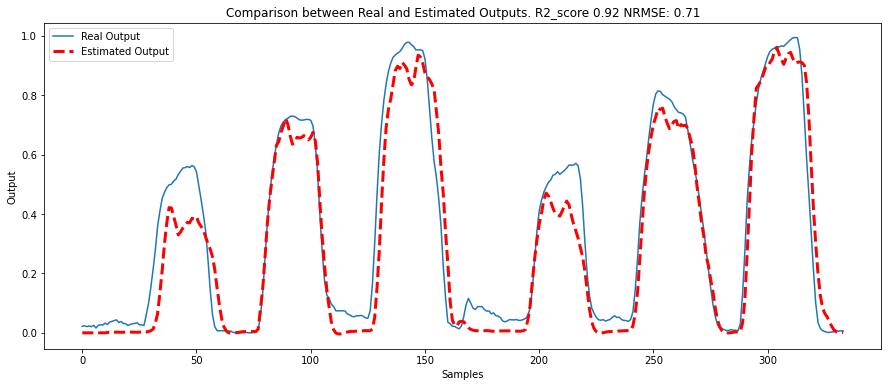

In [305]:
# Test the identified model
nit = len(y)
xest = np.zeros((n, nit))
yest = np.zeros(nit)
for k in range(10, nit):
    # Estimated plant output
    xest[:, k] = A @ xest[:, k-1] + B @ u[:, k-1]
    # Uncomment the next line if needed and define ex
    # xest[:, k] += GAMMA @ ex  
    yest[k] = C @ xest[:, k]

# Convert yest to a 1D array
yest = yest.flatten()

R2_SS=R2_coef(y,yest)
NRMSE_SS = NRMSE(y,yest)
# Display results
plt.figure(figsize=(15, 6))
plt.plot(y, label='Real Output')
plt.plot(yest, label='Estimated Output', linestyle='--', linewidth = 3, color = 'red')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title(f'Comparison between Real and Estimated Outputs. R2_score {R2_SS:.2f} NRMSE: {NRMSE_SS:.2f}')
plt.show()

### Estimation with Kalman Filter (minimum variance case) 

In [306]:
dqlr = pp.DLQRCalculator()

* Initial parameters

In [307]:
# Initialize variables and parameters
n = 4  # system order
W = X - xest.T
V = y - yest

# Calculate Qfk and Rfk
#Qfk = np.diag(np.var(W, axis=0))
Qfk = np.cov((W.T @ W), rowvar=False)
Qfk = GAMA @ Qfk @ GAMA.T

Rfk = np.var(W[:, 0])
# Compute Kalman gain
#L, K, = dqlr(A.T, C.reshape(-1, 1), Qfk, Rfk)

# Initialize state variables
xfk = np.zeros((n, 1))
x = np.zeros((n, 1))
yfk = np.zeros(len(y))
y_ = np.zeros(len(y))
time_measurements = np.zeros(len(y))



* Get Kaman Gain

In [322]:
L, P = dqlr(A,C.reshape(1,-1),Qfk,Rfk)

array([[ 3.43430120e-01],
       [-3.11606732e+01],
       [ 2.87728011e+02],
       [ 1.42860949e+06]])

* Force estimed with Kalman filter

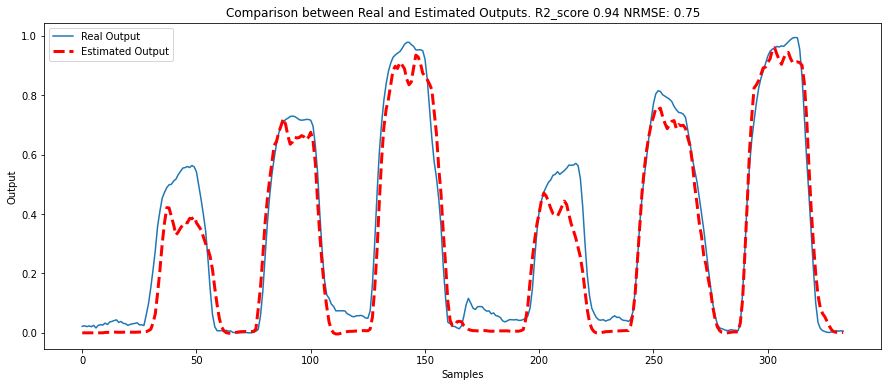

In [335]:
# Estimation using Kalman filter
x_est = np.zeros((n, nit))
x_fk = np.zeros((n, nit)) 
y_est = np.zeros(nit)

for k in range(10, nit):
    # Plant output estimation
    xest[:, k] = A @ xest[:, k-1] + B @ u[:, k-1]

    y_[k] = C @ xest[:, k]

    # Observer                       A-LC * xfk                                         B.U                        Ly
    x_fk[:, k] = (((A -L @ C.reshape(1,-1)) @ x_fk[:, k-1].reshape(-1,1)) + B @ u[:, k].reshape(-1,1) + L @ y_[k].reshape(-1,1)).T
    y_est[k] = C @ x_fk[:,k]

R2_SS_FK=R2_coef(y,y_est)
NRMSE_SS_FK = NRMSE(y,y_est)
# Display results
plt.figure(figsize=(15, 6))
plt.plot(y, label='Real Output')
plt.plot(y_est, label='Estimated Output', linestyle='--', linewidth = 3, color = 'red')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title(f'Comparison between Real and Estimated Outputs. R2_score {R2_SS_FK:.2f} NRMSE: {NRMSE_SS_FK:.2f}')
plt.show()